# Create a proof-of-concept LSTM streamflow prediction model

### Load datasets

### Define the train/validation/test splits

| Set        | Years                 | Count           |
| ---------- | --------------------- | --------------- |
| Train      | 1990–2006             | 17 years (~40%) |
| Validation | 2007–2010             | 4 years (~10%)  |
| Test       | 1980–1989 + 2011–2022 | 22 years (~50%) |


In [99]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
import os
from datetime import datetime
import pickle

# Configuration
SEQ_LENGTH = 365
LSTM_UNITS = 80
BATCH_SIZE = 16
CHUNK_SIZE = 4  # Process 50 stations at a time
STATIC_FEATURES = ['pct_glaciation', 'log_area']
DYNAMIC_FEATURES = ['max_temp', 'min_temp', 'area_scaled_precip', 'mean_temp']

class EntityAwareLSTMLayer(layers.Layer):
    """Entity-Aware LSTM Layer based on Kratzert et al. 2019
    
    Static features directly modulate the input gate, allowing entity-specific
    characteristics to influence what information flows into the cell state.
    """
    
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        
    def build(self, input_shape):
        # input_shape is a list: [dynamic_shape, static_shape]
        # dynamic_shape: (batch, seq_len, dynamic_features)
        # static_shape: (batch, static_features)
        dynamic_dim = input_shape[0][-1]
        static_dim = input_shape[1][-1]
        
        # Weights for dynamic input (for f, o, g gates combined)
        self.weight_ih = self.add_weight(
            shape=(dynamic_dim, 3 * self.units),
            initializer='orthogonal',
            name='weight_ih'
        )
        
        # Recurrent weights (for f, o, g gates combined)
        # Initialize as identity matrix repeated 3 times
        identity = tf.eye(self.units)
        identity_3x = tf.concat([identity, identity, identity], axis=1)
        self.weight_hh = self.add_weight(
            shape=(self.units, 3 * self.units),
            initializer=tf.constant_initializer(identity_3x.numpy()),
            name='weight_hh'
        )
        
        # Static feature weights (only for input gate)
        self.weight_sh = self.add_weight(
            shape=(static_dim, self.units),
            initializer='orthogonal',
            name='weight_sh'
        )
        
        # Biases
        self.bias = self.add_weight(
            shape=(3 * self.units,),
            initializer='zeros',
            name='bias'
        )
        
        self.bias_s = self.add_weight(
            shape=(self.units,),
            initializer='zeros',
            name='bias_s'
        )
        
        self.built = True
    
    def call(self, inputs, training=None):
        x_dynamic, x_static = inputs
        batch_size = tf.shape(x_dynamic)[0]
        seq_len = tf.shape(x_dynamic)[1]
        
        # Initialize hidden and cell states
        h = tf.zeros((batch_size, self.units), dtype=x_dynamic.dtype)
        c = tf.zeros((batch_size, self.units), dtype=x_dynamic.dtype)
        
        # Calculate input gate once (static features don't change over time)
        # i = sigmoid(x_static @ weight_sh + bias_s)
        i = tf.sigmoid(tf.matmul(x_static, self.weight_sh) + self.bias_s)
        
        # Define the step function for processing each timestep
        def step_fn(t, h, c, h_list):
            x_t = x_dynamic[:, t, :]
            
            # Calculate forget, output, and cell candidate gates
            # gates = x_t @ weight_ih + h @ weight_hh + bias
            gates = tf.matmul(x_t, self.weight_ih) + tf.matmul(h, self.weight_hh) + self.bias
            
            # Split into forget, output, and cell candidate
            f, o, g = tf.split(gates, 3, axis=1)
            
            # Update cell state
            # c = sigmoid(f) * c + i * tanh(g)
            c_new = tf.sigmoid(f) * c + i * tf.tanh(g)
            
            # Update hidden state
            # h = sigmoid(o) * tanh(c)
            h_new = tf.sigmoid(o) * tf.tanh(c_new)
            
            # Append to list
            h_list = h_list.write(t, h_new)
            
            return t + 1, h_new, c_new, h_list
        
        # Create TensorArray to store hidden states
        h_array = tf.TensorArray(dtype=x_dynamic.dtype, size=seq_len)
        
        # Use while_loop to iterate through sequence
        _, h_final, c_final, h_array = tf.while_loop(
            cond=lambda t, *_: t < seq_len,
            body=step_fn,
            loop_vars=[0, h, c, h_array]
        )
        
        # Return final hidden state
        return h_final  # (batch, units)
    
    def compute_output_shape(self, input_shape):
        # Return shape of final hidden state
        return (input_shape[0][0], self.units)

class ChunkedDataProcessor:
    """Process large datasets in chunks to avoid memory issues"""
    
    def __init__(self, seq_length=365):
        self.seq_length = seq_length
        self.scalers = {
            'temp': StandardScaler(),  # Global for all temperature fields
            'area_scaled_precip': StandardScaler(),  # Global for area-scaled precip
            'static': StandardScaler(),  # Global for static features
            'target': {}  # Per-station for streamflow
        }
        
    def load_and_prepare_data(self):
        """Load all data files and prepare metadata"""
        print("Loading data files...")
        
        # Load climate data
        max_temp = pd.read_csv('basin_averaged_climate_data/basin_max_temperature.csv', 
                               index_col=0, parse_dates=True)
        min_temp = pd.read_csv('basin_averaged_climate_data/basin_min_temperature.csv',
                               index_col=0, parse_dates=True)
        precip = pd.read_csv('basin_averaged_climate_data/basin_total_precipitation.csv',
                            index_col=0, parse_dates=True)
        mean_temp = pd.read_csv('basin_averaged_climate_data/basin_mean_temperature.csv',
                               index_col=0, parse_dates=True)
        
        # Load target data
        streamflow = pd.read_csv('combined_streamflow_cleaned.csv',
                                index_col=0, parse_dates=True)
        
        # Load static features
        metadata = pd.read_csv('station_cluster_metadata.csv')
        metadata['log_area'] = np.log(metadata['Area_km2'])
        
        # Align all datasets
        common_dates = max_temp.index.intersection(min_temp.index)\
                                      .intersection(precip.index)\
                                      .intersection(mean_temp.index)\
                                      .intersection(streamflow.index)
        common_stations = list(set(max_temp.columns) & 
                              set(min_temp.columns) & 
                              set(precip.columns) & 
                              set(mean_temp.columns) &
                              set(streamflow.columns) &
                              set(metadata['StationNum'].astype(str)))
        
        print(f"Found {len(common_dates)} common dates and {len(common_stations)} stations")
        
        # Sort and filter
        common_dates = sorted(common_dates)
        max_temp = max_temp.loc[common_dates, common_stations].astype(np.float32)
        min_temp = min_temp.loc[common_dates, common_stations].astype(np.float32)
        precip = precip.loc[common_dates, common_stations].astype(np.float32)
        mean_temp = mean_temp.loc[common_dates, common_stations].astype(np.float32)
        streamflow = streamflow.loc[common_dates, common_stations].astype(np.float32)
        
        metadata = metadata[metadata['StationNum'].astype(str).isin(common_stations)]
        metadata = metadata.set_index('StationNum')
        metadata = metadata.loc[[int(s) if s.isdigit() else s for s in common_stations]]
        
        # Create area-scaled precipitation
        print("Creating area-scaled precipitation...")
        area_scaled_precip = precip.copy()
        for station in common_stations:
            station_key = int(station) if station.isdigit() else station
            area = metadata.loc[station_key, 'Area_km2']
            area_scaled_precip[station] = precip[station] / area
        
        return {
            'max_temp': max_temp,
            'min_temp': min_temp,
            'precip': precip,
            'area_scaled_precip': area_scaled_precip,
            'mean_temp': mean_temp,
            'streamflow': streamflow,
            'metadata': metadata,
            'dates': common_dates,
            'stations': common_stations
        }
    
    def create_temporal_splits(self, dates):
        """Create train/val/test splits: 40/10/50 with training in middle years"""
        df_dates = pd.DataFrame({'date': dates})
        df_dates['year'] = df_dates['date'].dt.year
        
        years = sorted(df_dates['year'].unique())
        n_years = len(years)
        
        # Split: first 25% test, middle 40% train, next 10% val, last 25% test
        # This puts training data in the middle to avoid stationarity issues
        test1_end = int(0.25 * n_years)
        train_end = test1_end + int(0.4 * n_years)
        val_end = train_end + int(0.1 * n_years)
        
        test1_years = years[:test1_end]
        train_years = years[test1_end:train_end]
        val_years = years[train_end:val_end]
        test2_years = years[val_end:]
        
        # Combine test sets
        test_years = test1_years + test2_years
        
        train_mask = df_dates['year'].isin(train_years).values
        val_mask = df_dates['year'].isin(val_years).values
        test_mask = df_dates['year'].isin(test_years).values
        
        print(f"Train years (middle): {train_years[0]}-{train_years[-1]} ({len(train_years)} years)")
        print(f"Val years: {val_years[0]}-{val_years[-1]} ({len(val_years)} years)")
        print(f"Test years (early+late): {test1_years[0]}-{test1_years[-1]}, "
              f"{test2_years[0]}-{test2_years[-1]} ({len(test_years)} years)")
        
        return train_mask, val_mask, test_mask
    
    def fit_scalers(self, data_dict, train_mask):
        """Fit scalers on training data"""
        print("Fitting scalers on training data...")
        
        # Fit temperature scaler (global for all temp fields)
        temp_train = np.column_stack([
            data_dict['max_temp'].values[train_mask].flatten(),
            data_dict['min_temp'].values[train_mask].flatten(),
            data_dict['mean_temp'].values[train_mask].flatten()
        ]).astype(np.float32)
        temp_train = temp_train[~np.isnan(temp_train).any(axis=1)]
        self.scalers['temp'].fit(temp_train)
        
        # Fit area-scaled precipitation scaler (global)
        precip_train = data_dict['area_scaled_precip'].values[train_mask].flatten()
        precip_train = precip_train[~np.isnan(precip_train)].reshape(-1, 1).astype(np.float32)
        self.scalers['area_scaled_precip'].fit(precip_train)
        
        # Fit static scaler (global)
        static_data = data_dict['metadata'][STATIC_FEATURES].values.astype(np.float32)
        self.scalers['static'].fit(static_data)
        
        # Fit per-station target scalers
        print("Fitting per-station streamflow scalers...")
        for station in data_dict['stations']:
            station_flow = data_dict['streamflow'][station].values[train_mask]
            station_flow = station_flow[~np.isnan(station_flow)].reshape(-1, 1).astype(np.float32)
            
            scaler = StandardScaler()
            scaler.fit(station_flow)
            self.scalers['target'][station] = scaler
        
        print("Scalers fitted successfully")
    
    def create_sequences_chunked(self, data_dict, mask, station_chunk):
        """Create sequences for a chunk of stations"""
        stations = data_dict['stations']
        chunk_stations = stations[station_chunk[0]:station_chunk[1]]
        
        X_dynamic_list = []
        X_static_list = []
        y_list = []
        
        for station in chunk_stations:
            station_key = int(station) if station.isdigit() else station
            
            # Extract temperature data
            temps = np.column_stack([
                data_dict['max_temp'][station].values,
                data_dict['min_temp'][station].values,
                data_dict['mean_temp'][station].values
            ]).astype(np.float32)
            
            # Normalize temperatures using global scaler
            temps_scaled = self.scalers['temp'].transform(temps)
            
            # Extract and normalize area-scaled precipitation
            precip = data_dict['area_scaled_precip'][station].values.reshape(-1, 1).astype(np.float32)
            precip_scaled = self.scalers['area_scaled_precip'].transform(precip)
            
            # Combine dynamic features
            station_data = np.column_stack([
                temps_scaled[:, 0],  # max_temp
                temps_scaled[:, 1],  # min_temp
                precip_scaled.flatten(),  # area_scaled_precip
                temps_scaled[:, 2]   # mean_temp
            ]).astype(np.float32)
            
            # Extract and normalize target (per-station)
            target = data_dict['streamflow'][station].values.astype(np.float32)
            target_scaled = self.scalers['target'][station].transform(
                target.reshape(-1, 1)
            ).astype(np.float32)
            
            # Apply mask
            station_data = station_data[mask]
            target_scaled = target_scaled[mask]
            
            # Create sequences
            for i in range(len(station_data) - self.seq_length):
                X_dynamic_list.append(station_data[i:i+self.seq_length].astype(np.float16))
                y_list.append(target_scaled[i+self.seq_length])
                
                # Static features (normalized)
                static_idx = data_dict['metadata'].index.get_loc(station_key)
                static_feat = data_dict['metadata'].iloc[static_idx][STATIC_FEATURES].values
                static_feat = self.scalers['static'].transform(static_feat.reshape(1, -1))
                X_static_list.append(static_feat[0].astype(np.float16))
        
        return (np.array(X_dynamic_list, dtype=np.float16),
                np.array(X_static_list, dtype=np.float16),
                np.array(y_list, dtype=np.float16))
    
    def prepare_dataset(self, data_dict, mask, chunk_size=CHUNK_SIZE):
        """Prepare dataset by processing stations in chunks"""
        n_stations = len(data_dict['stations'])
        n_chunks = (n_stations + chunk_size - 1) // chunk_size
        
        X_dynamic_all = []
        X_static_all = []
        y_all = []
        
        for chunk_idx in range(n_chunks):
            start_idx = chunk_idx * chunk_size
            end_idx = min((chunk_idx + 1) * chunk_size, n_stations)
            
            print(f"Processing chunk {chunk_idx+1}/{n_chunks} (stations {start_idx}-{end_idx})")
            
            X_dyn, X_stat, y = self.create_sequences_chunked(
                data_dict, mask, (start_idx, end_idx)
            )
            
            X_dynamic_all.append(X_dyn)
            X_static_all.append(X_stat)
            y_all.append(y)
            
            # Clear memory
            del X_dyn, X_stat, y
        
        X_dynamic = np.concatenate(X_dynamic_all, axis=0)
        X_static = np.concatenate(X_static_all, axis=0)
        y = np.concatenate(y_all, axis=0)
        
        print(f"Created {len(X_dynamic)} sequences")
        
        return X_dynamic, X_static, y

def create_ea_lstm_model(seq_length, n_dynamic_features, n_static_features, lstm_units=80):
    """Create Entity-Aware LSTM model with static features in input gate"""
    
    # Dynamic input (time series)
    dynamic_input = layers.Input(shape=(seq_length, n_dynamic_features), name='dynamic_input')
    
    # Static input (entity features)
    static_input = layers.Input(shape=(n_static_features,), name='static_input')
    
    # Optional: Time-distributed dense encoding of dynamic features
    encoded_dynamic = layers.TimeDistributed(
        layers.Dense(n_dynamic_features, activation='tanh')
    )(dynamic_input)
    
    # Apply EA-LSTM layer
    ea_lstm = EntityAwareLSTMLayer(lstm_units, name='ea_lstm')
    lstm_out = ea_lstm([encoded_dynamic, static_input])
    
    # Output layers
    x = layers.Dense(64, activation='relu')(lstm_out)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(32, activation='relu')(x)
    output = layers.Dense(1, name='streamflow_output')(x)
    
    model = keras.Model(
        inputs=[dynamic_input, static_input],
        outputs=output,
        name='EA_LSTM_Streamflow'
    )
    
    return model

# Main execution
if __name__ == "__main__":
    print("="*50)
    print("Entity-Aware LSTM for Streamflow Prediction")
    print("="*50)
    
    # Initialize processor
    processor = ChunkedDataProcessor(seq_length=SEQ_LENGTH)
    
    # Load data
    data_dict = processor.load_and_prepare_data()
    
    # Create temporal splits (40/10/50 with training in middle)
    train_mask, val_mask, test_mask = processor.create_temporal_splits(data_dict['dates'])
    
    # Fit scalers on training data
    processor.fit_scalers(data_dict, train_mask)
    
    # Save scalers
    with open('scalers.pkl', 'wb') as f:
        pickle.dump(processor.scalers, f)
    print("Scalers saved to scalers.pkl")
    
    # Prepare datasets
    print("\nPreparing training data...")
    X_train_dyn, X_train_stat, y_train = processor.prepare_dataset(data_dict, train_mask)
    
    print("\nPreparing validation data...")
    X_val_dyn, X_val_stat, y_val = processor.prepare_dataset(data_dict, val_mask)
    
    # print("\nPreparing test data...")
    # X_test_dyn, X_test_stat, y_test = processor.prepare_dataset(data_dict, test_mask)
    
    # Create model
    print("\nCreating EA-LSTM model...")
    model = create_ea_lstm_model(
        seq_length=SEQ_LENGTH,
        n_dynamic_features=len(DYNAMIC_FEATURES),
        n_static_features=len(STATIC_FEATURES),
        lstm_units=LSTM_UNITS
    )
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    print(model.summary())
    
    # Train model
    print("\nTraining model...")
    history = model.fit(
        [X_train_dyn, X_train_stat],
        y_train,
        validation_data=([X_val_dyn, X_val_stat], y_val),
        epochs=5,
        batch_size=BATCH_SIZE,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5),
            keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
        ],
        verbose=1
    )
    
    # # Evaluate on test set
    # print("\nEvaluating on test set...")
    # test_loss, test_mae = model.evaluate([X_test_dyn, X_test_stat], y_test)
    # print(f"Test MSE: {test_loss:.6f}")
    # print(f"Test MAE: {test_mae:.6f}")
    
    # Save final model
    model.save('ea_lstm_final.keras')
    
    print("\nModel training complete!")
    print(f"Model saved to: ea_lstm_final.keras")
    print(f"Scalers saved to: scalers.pkl")

Entity-Aware LSTM for Streamflow Prediction
Loading data files...
Found 15706 common dates and 111 stations
Creating area-scaled precipitation...
Train years (middle): 1990-2006 (17 years)
Val years: 2007-2010 (4 years)
Test years (early+late): 1980-1989, 2011-2022 (22 years)
Fitting scalers on training data...
Fitting per-station streamflow scalers...
Scalers fitted successfully
Scalers saved to scalers.pkl

Preparing training data...
Processing chunk 1/28 (stations 0-4)
Processing chunk 2/28 (stations 4-8)
Processing chunk 3/28 (stations 8-12)
Processing chunk 4/28 (stations 12-16)
Processing chunk 5/28 (stations 16-20)
Processing chunk 6/28 (stations 20-24)
Processing chunk 7/28 (stations 24-28)
Processing chunk 8/28 (stations 28-32)
Processing chunk 9/28 (stations 32-36)
Processing chunk 10/28 (stations 36-40)
Processing chunk 11/28 (stations 40-44)
Processing chunk 12/28 (stations 44-48)
Processing chunk 13/28 (stations 48-52)
Processing chunk 14/28 (stations 52-56)
Processing chu

Model: "EA_LSTM_Streamflow"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ dynamic_input       │ (None, 365, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_58 (Cast)      │ (None, 365, 4)    │          0 │ dynamic_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_input        │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 365, 4)    │         20 │ cast_58[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_59 (Cast)      │ (None, 2)         │          0 │ static_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ea_lstm             │ (None, 80)        │     20,640 │ time_distributed… │
│ (EntityAwareLSTMLa… │                   │            │ cast_59[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │      5,184 │ ea_lstm[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 32)        │      2,080 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ streamflow_output   │ (None, 1)         │         33 │ dense_17[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,957 (109.21 KB)

 Trainable params: 27,957 (109.21 KB)

 Non-trainable params: 0 (0.00 B)

None

Training model...
Epoch 1/5


C:\Users\tbwil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['dynamic_input', 'static_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


40543/40543 ━━━━━━━━━━━━━━━━━━━━ 6351s 156ms/step - loss: 0.6909 - mae: 0.3549 - val_loss: 0.5599 - val_mae: 0.3005 - learning_rate: 0.0010
Epoch 2/5
40543/40543 ━━━━━━━━━━━━━━━━━━━━ 6402s 158ms/step - loss: 0.6529 - mae: 0.3386 - val_loss: 0.5870 - val_mae: 0.3399 - learning_rate: 0.0010
Epoch 3/5
40543/40543 ━━━━━━━━━━━━━━━━━━━━ 5627s 139ms/step - loss: 0.6268 - mae: 0.3228 - val_loss: 0.5758 - val_mae: 0.3747 - learning_rate: 0.0010
Epoch 4/5
40543/40543 ━━━━━━━━━━━━━━━━━━━━ 5466s 135ms/step - loss: 0.5369 - mae: 0.3075 - val_loss: 0.5571 - val_mae: 0.3689 - learning_rate: 0.0010
Epoch 5/5
40543/40543 ━━━━━━━━━━━━━━━━━━━━ 5387s 133ms/step - loss: 0.5374 - mae: 0.2995 - val_loss: 0.5704 - val_mae: 0.3993 - learning_rate: 0.0010

Model training complete!
Model saved to: ea_lstm_final.keras
Scalers saved to: scalers.pkl


EA-LSTM Model Evaluation
Loading model from best_model.keras...
Loading scalers from scalers.pkl...

Loading data for station 05BB001...
Station metadata:
  Area: 2210.45 km²
  Glaciation: 2.69%
  Available data: 1979-12-31 00:00:00 to 2022-12-31 00:00:00

Prepared 365 sequences
Prediction period: 2009-01-01 00:00:00 to 2009-12-31 00:00:00
Making predictions...


C:\Users\tbwil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['dynamic_input', 'static_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 378ms/step

Nash-Sutcliffe Efficiency (NSE): 0.7823

Evaluation Statistics
NSE                 :     0.7823
RMSE                :    14.0736
MAE                 :    12.7467
Correlation         :     0.9455
Bias                :     9.7668
Percent Bias        :    32.8315


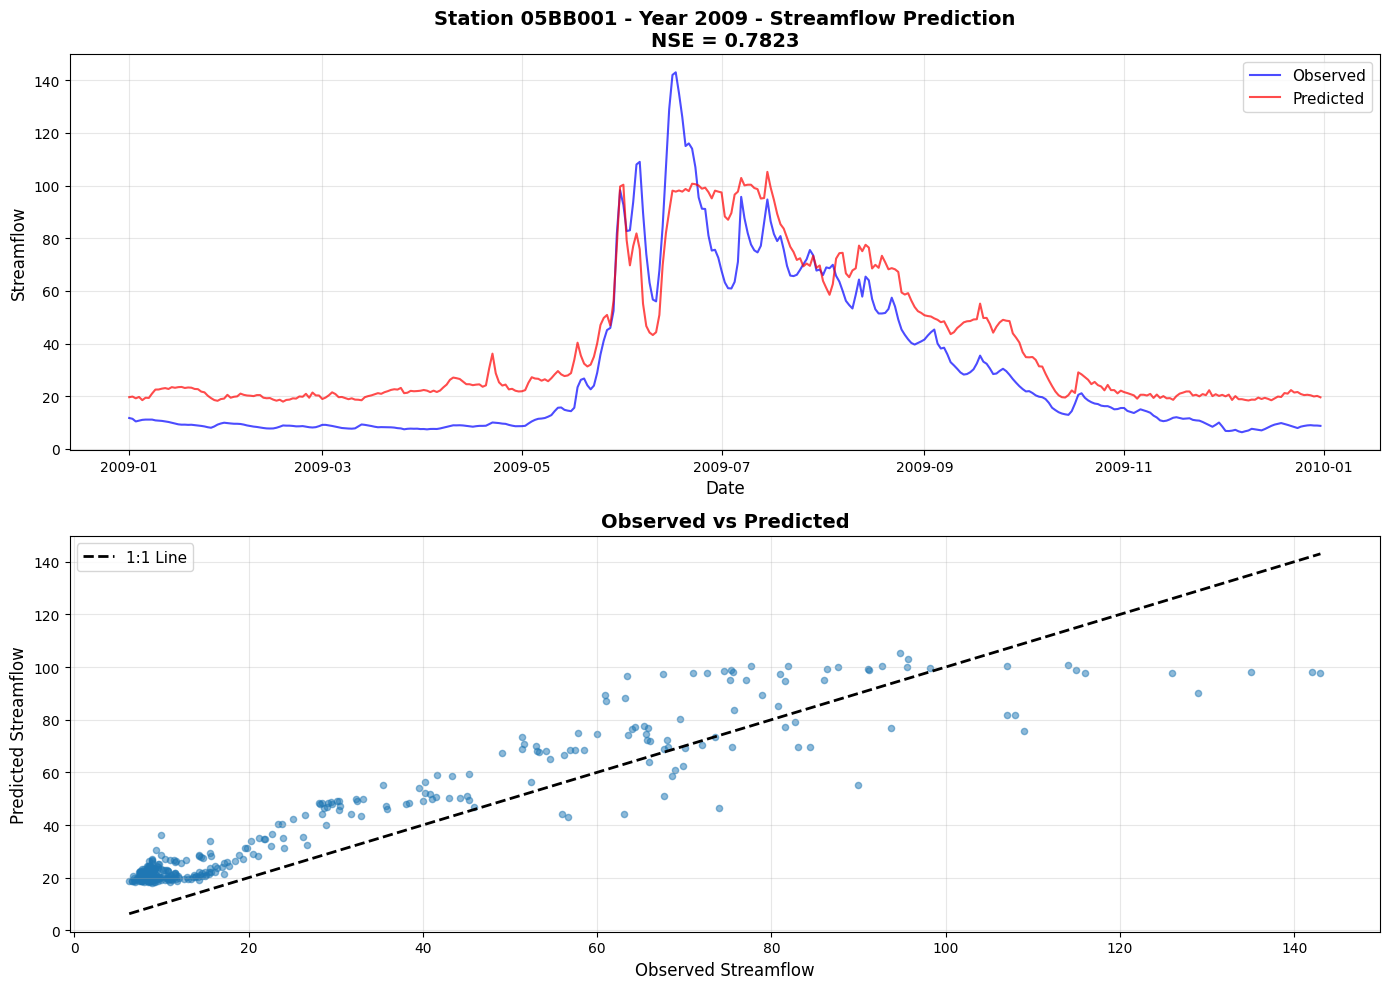


Evaluation complete!


In [134]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pickle
from datetime import datetime

# ============================================================================
# Custom EA-LSTM Layer (needed for loading the model)
# ============================================================================

class EntityAwareLSTMLayer(layers.Layer):
    """Entity-Aware LSTM Layer based on Kratzert et al. 2019
    
    Static features directly modulate the input gate, allowing entity-specific
    characteristics to influence what information flows into the cell state.
    """
    
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        
    def build(self, input_shape):
        # input_shape is a list: [dynamic_shape, static_shape]
        dynamic_dim = input_shape[0][-1]
        static_dim = input_shape[1][-1]
        
        # Weights for dynamic input (for f, o, g gates combined)
        self.weight_ih = self.add_weight(
            shape=(dynamic_dim, 3 * self.units),
            initializer='orthogonal',
            name='weight_ih'
        )
        
        # Recurrent weights (for f, o, g gates combined)
        identity = tf.eye(self.units)
        identity_3x = tf.concat([identity, identity, identity], axis=1)
        self.weight_hh = self.add_weight(
            shape=(self.units, 3 * self.units),
            initializer=tf.constant_initializer(identity_3x.numpy()),
            name='weight_hh'
        )
        
        # Static feature weights (only for input gate)
        self.weight_sh = self.add_weight(
            shape=(static_dim, self.units),
            initializer='orthogonal',
            name='weight_sh'
        )
        
        # Biases
        self.bias = self.add_weight(
            shape=(3 * self.units,),
            initializer='zeros',
            name='bias'
        )
        
        self.bias_s = self.add_weight(
            shape=(self.units,),
            initializer='zeros',
            name='bias_s'
        )
        
        self.built = True
    
    def call(self, inputs, training=None):
        x_dynamic, x_static = inputs
        batch_size = tf.shape(x_dynamic)[0]
        seq_len = tf.shape(x_dynamic)[1]
        
        # Initialize hidden and cell states
        h = tf.zeros((batch_size, self.units), dtype=x_dynamic.dtype)
        c = tf.zeros((batch_size, self.units), dtype=x_dynamic.dtype)
        
        # Calculate input gate once (static features don't change over time)
        i = tf.sigmoid(tf.matmul(x_static, self.weight_sh) + self.bias_s)
        
        # Define the step function for processing each timestep
        def step_fn(t, h, c, h_list):
            x_t = x_dynamic[:, t, :]
            
            # Calculate forget, output, and cell candidate gates
            gates = tf.matmul(x_t, self.weight_ih) + tf.matmul(h, self.weight_hh) + self.bias
            
            # Split into forget, output, and cell candidate
            f, o, g = tf.split(gates, 3, axis=1)
            
            # Update cell state
            c_new = tf.sigmoid(f) * c + i * tf.tanh(g)
            
            # Update hidden state
            h_new = tf.sigmoid(o) * tf.tanh(c_new)
            
            # Append to list
            h_list = h_list.write(t, h_new)
            
            return t + 1, h_new, c_new, h_list
        
        # Create TensorArray to store hidden states
        h_array = tf.TensorArray(dtype=x_dynamic.dtype, size=seq_len)
        
        # Use while_loop to iterate through sequence
        _, h_final, c_final, h_array = tf.while_loop(
            cond=lambda t, *_: t < seq_len,
            body=step_fn,
            loop_vars=[0, h, c, h_array]
        )
        
        # Return final hidden state
        return h_final
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], self.units)
    
    def get_config(self):
        config = super().get_config()
        config.update({"units": self.units})
        return config

# ============================================================================
# Evaluation Functions
# ============================================================================

def load_model_and_scalers(model_path='best_model.keras', scalers_path='scalers.pkl'):
    """Load the trained model and scalers"""
    print(f"Loading model from {model_path}...")
    
    # Load model with custom objects
    model = keras.models.load_model(
        model_path,
        custom_objects={'EntityAwareLSTMLayer': EntityAwareLSTMLayer}
    )
    
    print(f"Loading scalers from {scalers_path}...")
    with open(scalers_path, 'rb') as f:
        scalers = pickle.load(f)
    
    return model, scalers

def calculate_nse(observed, predicted):
    """Calculate Nash-Sutcliffe Efficiency"""
    # Remove NaN values
    mask = ~(np.isnan(observed) | np.isnan(predicted))
    observed = observed[mask]
    predicted = predicted[mask]
    
    if len(observed) == 0:
        return np.nan
    
    numerator = np.sum((observed - predicted) ** 2)
    denominator = np.sum((observed - np.mean(observed)) ** 2)
    
    if denominator == 0:
        return np.nan
    
    nse = 1 - (numerator / denominator)
    return nse

def load_station_data(station, year=None, seq_length=365):
    """Load data for a specific station
    
    Note: Loads full time series to ensure we have enough historical data
    for sequence creation. Year filtering is applied after sequences are created.
    """
    print(f"\nLoading data for station {station}...")
    
    # Load climate data
    max_temp = pd.read_csv('basin_averaged_climate_data/basin_max_temperature.csv', 
                           index_col=0, parse_dates=True)
    min_temp = pd.read_csv('basin_averaged_climate_data/basin_min_temperature.csv',
                           index_col=0, parse_dates=True)
    precip = pd.read_csv('basin_averaged_climate_data/basin_total_precipitation.csv',
                        index_col=0, parse_dates=True)
    mean_temp = pd.read_csv('basin_averaged_climate_data/basin_mean_temperature.csv',
                           index_col=0, parse_dates=True)
    
    # Load target data
    streamflow = pd.read_csv('combined_streamflow_cleaned.csv',
                            index_col=0, parse_dates=True)
    
    # Load static features
    metadata = pd.read_csv('station_cluster_metadata.csv')
    metadata['log_area'] = np.log(metadata['Area_km2'])
    metadata = metadata.set_index('StationNum')
    
    # Filter for station
    station_str = str(station)
    if station_str not in max_temp.columns:
        raise ValueError(f"Station {station} not found in data")
    
    # Get station metadata
    station_key = int(station) if station_str.isdigit() else station
    if station_key not in metadata.index:
        raise ValueError(f"Station {station} not found in metadata")
    
    station_metadata = metadata.loc[station_key]
    
    # Extract FULL time series (don't filter by year yet)
    data = pd.DataFrame({
        'max_temp': max_temp[station_str],
        'min_temp': min_temp[station_str],
        'precip': precip[station_str],
        'mean_temp': mean_temp[station_str],
        'streamflow': streamflow[station_str]
    })
    
    # If year is specified, check that we have data for that year
    # but don't filter yet - we need prior data for sequences
    if year is not None:
        year_data = data[data.index.year == year]
        if len(year_data) == 0:
            raise ValueError(f"No data found for station {station} in year {year}")
        
        # Check we have enough prior data (need seq_length days before the year)
        year_start = pd.Timestamp(f'{year}-01-01')
        if data.index[0] > year_start - pd.Timedelta(days=seq_length):
            print(f"Warning: Limited historical data before {year}. Predictions may be less accurate.")
    
    return data, station_metadata

def prepare_sequences(data, station_metadata, scalers, seq_length=365, target_year=None):
    """Prepare sequences for prediction
    
    Parameters:
    -----------
    data : DataFrame
        Full time series data
    station_metadata : Series
        Station metadata
    scalers : dict
        Dictionary of fitted scalers
    seq_length : int
        Length of input sequences (default 365)
    target_year : int or None
        If specified, only return predictions for this year
    
    Returns:
    --------
    X_dynamic, X_static : arrays
        Input sequences
    y_indices : list
        Indices in the original data corresponding to predictions
    dates : DatetimeIndex
        Dates corresponding to predictions
    """
    
    # Calculate area-scaled precipitation
    area = np.exp(station_metadata['log_area'])
    area_scaled_precip = data['precip'].values / area
    
    # Prepare temperature data
    temps = np.column_stack([
        data['max_temp'].values,
        data['min_temp'].values,
        data['mean_temp'].values
    ]).astype(np.float32)
    
    # Normalize temperatures
    temps_scaled = scalers['temp'].transform(temps)
    
    # Normalize area-scaled precipitation
    precip_scaled = scalers['area_scaled_precip'].transform(
        area_scaled_precip.reshape(-1, 1)
    )
    
    # Combine dynamic features
    dynamic_data = np.column_stack([
        temps_scaled[:, 0],  # max_temp
        temps_scaled[:, 1],  # min_temp
        precip_scaled.flatten(),  # area_scaled_precip
        temps_scaled[:, 2]   # mean_temp
    ]).astype(np.float32)
    
    # Prepare static features
    static_features = np.array([
        station_metadata['pct_glaciation'],
        station_metadata['log_area']
    ]).reshape(1, -1).astype(np.float32)
    static_scaled = scalers['static'].transform(static_features)
    
    # Create sequences for all possible dates
    X_dynamic_all = []
    y_indices_all = []
    
    for i in range(len(dynamic_data) - seq_length):
        X_dynamic_all.append(dynamic_data[i:i+seq_length])
        y_indices_all.append(i + seq_length)
    
    # Filter by year if specified
    if target_year is not None:
        # Get indices where prediction date is in target year
        prediction_dates = data.index[y_indices_all]
        year_mask = prediction_dates.year == target_year
        
        # Filter sequences
        X_dynamic = [X_dynamic_all[i] for i in range(len(X_dynamic_all)) if year_mask[i]]
        y_indices = [y_indices_all[i] for i in range(len(y_indices_all)) if year_mask[i]]
        
        if len(X_dynamic) == 0:
            raise ValueError(f"No valid sequences found for year {target_year}")
        
        X_dynamic = np.array(X_dynamic, dtype=np.float16)
    else:
        X_dynamic = np.array(X_dynamic_all, dtype=np.float16)
        y_indices = y_indices_all
    
    # Repeat static features for each sequence
    X_static = np.repeat(static_scaled, len(X_dynamic), axis=0).astype(np.float16)
    
    # Get corresponding dates
    dates = data.index[y_indices]
    
    return X_dynamic, X_static, y_indices, dates

def evaluate_station(model, scalers, station, year=None, seq_length=365, no_glac = False):
    """Evaluate model on a specific station and year"""
    
    # Load full data (not filtered by year yet)
    data, station_metadata = load_station_data(station, year, seq_length)

    # convert glaciation percent to 0 if no_glac is True
    if no_glac:
        station_metadata['pct_glaciation'] = 0.0
    
    print(f"Station metadata:")
    print(f"  Area: {np.exp(station_metadata['log_area']):.2f} km²")
    print(f"  Glaciation: {station_metadata['pct_glaciation']:.2f}%")
    print(f"  Available data: {data.index[0]} to {data.index[-1]}")
    
    # Prepare sequences (filtering by year happens here)
    X_dynamic, X_static, y_indices, dates = prepare_sequences(
        data, station_metadata, scalers, seq_length, target_year=year
    )
    
    print(f"\nPrepared {len(X_dynamic)} sequences")
    if year:
        print(f"Prediction period: {dates[0]} to {dates[-1]}")
    
    # Make predictions
    print("Making predictions...")
    predictions_scaled = model.predict([X_dynamic, X_static], batch_size=32, verbose=1)
    
    # Get station-specific scaler
    station_str = str(station)
    if station_str not in scalers['target']:
        raise ValueError(f"No scaler found for station {station}")
    
    station_scaler = scalers['target'][station_str]
    
    # Inverse transform predictions
    predictions = station_scaler.inverse_transform(predictions_scaled).flatten()
    
    # Get observed values
    observed = data['streamflow'].iloc[y_indices].values
    
    # Calculate NSE
    nse = calculate_nse(observed, predictions)
    
    print(f"\nNash-Sutcliffe Efficiency (NSE): {nse:.4f}")
    
    return dates, observed, predictions, nse

def plot_results(dates, observed, predicted, nse, station, year=None):
    """Plot observed vs predicted streamflow"""
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Time series plot
    ax = axes[0]
    ax.plot(dates, observed, label='Observed', color='blue', linewidth=1.5, alpha=0.7)
    ax.plot(dates, predicted, label='Predicted', color='red', linewidth=1.5, alpha=0.7)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Streamflow', fontsize=12)
    
    year_str = f" - Year {year}" if year else ""
    ax.set_title(f'Station {station}{year_str} - Streamflow Prediction\nNSE = {nse:.4f}', 
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Scatter plot
    ax = axes[1]
    ax.scatter(observed, predicted, alpha=0.5, s=20)
    
    # Add 1:1 line
    min_val = min(np.nanmin(observed), np.nanmin(predicted))
    max_val = max(np.nanmax(observed), np.nanmax(predicted))
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='1:1 Line')
    
    ax.set_xlabel('Observed Streamflow', fontsize=12)
    ax.set_ylabel('Predicted Streamflow', fontsize=12)
    ax.set_title('Observed vs Predicted', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # # Save figure
    # year_str = f"_{year}" if year else ""
    # filename = f'station_{station}{year_str}_evaluation.png'
    # plt.savefig(filename, dpi=300, bbox_inches='tight')
    # print(f"\nPlot saved to: {filename}")
    
    plt.show()

def calculate_statistics(observed, predicted):
    """Calculate additional statistics"""
    mask = ~(np.isnan(observed) | np.isnan(predicted))
    obs = observed[mask]
    pred = predicted[mask]
    
    if len(obs) == 0:
        return {}
    
    # NSE
    nse = calculate_nse(observed, predicted)
    
    # RMSE
    rmse = np.sqrt(np.mean((obs - pred) ** 2))
    
    # MAE
    mae = np.mean(np.abs(obs - pred))
    
    # Correlation
    correlation = np.corrcoef(obs, pred)[0, 1]
    
    # Bias
    bias = np.mean(pred - obs)
    
    # Percent bias
    pbias = 100 * np.sum(pred - obs) / np.sum(obs)
    
    return {
        'NSE': nse,
        'RMSE': rmse,
        'MAE': mae,
        'Correlation': correlation,
        'Bias': bias,
        'Percent Bias': pbias
    }

# ============================================================================
# Main Evaluation
# ============================================================================

if __name__ == "__main__":
    
    # Configuration
    STATION = '05BB001'
    YEAR = 2009  # Change this to your desired year, or set to None for all years
    MODEL_PATH = 'best_model.keras'
    SCALERS_PATH = 'scalers.pkl'
    SEQ_LENGTH = 365
    
    print("="*70)
    print("EA-LSTM Model Evaluation")
    print("="*70)
    
    # Load model and scalers
    model, scalers = load_model_and_scalers(MODEL_PATH, SCALERS_PATH)
    
    # print("\nModel summary:")
    # model.summary()
    
    # Evaluate on specified station and year
    dates, observed, predicted, nse = evaluate_station(
        model, scalers, STATION, YEAR, SEQ_LENGTH, no_glac = False
    )
    
    # Calculate detailed statistics
    print("\n" + "="*70)
    print("Evaluation Statistics")
    print("="*70)
    stats = calculate_statistics(observed, predicted)
    for metric, value in stats.items():
        print(f"{metric:20s}: {value:10.4f}")
    
    # Plot results
    plot_results(dates, observed, predicted, nse, STATION, YEAR)
    
    print("\n" + "="*70)
    print("Evaluation complete!")
    print("="*70)

In [112]:
years = range(2007, 2011) # validation years

meta = pd.read_csv('station_cluster_metadata.csv')
stations = meta['StationNum'].astype(str).tolist()

MODEL_PATH = 'best_model.keras'
SCALERS_PATH = 'scalers.pkl'
SEQ_LENGTH = 365

# Load model and scalers
model, scalers = load_model_and_scalers(MODEL_PATH, SCALERS_PATH)

station_avg_nse = {}

for station in stations:
    station_nse_sum = 0
    for year in years:
        # Evaluate on specified station and year
        dates, observed, predicted, nse = evaluate_station(
            model, scalers, station, year, SEQ_LENGTH
        )
        station_nse_sum += nse
    station_avg_nse[station] = station_nse_sum / len(years)

total_nse = sum(station_avg_nse.values()) / len(station_avg_nse)
print(f"Average NSE over validation years (2007-2010): {total_nse:.4f}\n")
for station, avg_nse in station_avg_nse.items():
    print(f"Station {station}: Average NSE = {avg_nse:.4f}")

Loading model from best_model.keras...
Loading scalers from scalers.pkl...

Loading data for station 05AA004...
Station metadata:
  Area: 160.56 km²
  Glaciation: 0.00%
  Available data: 1979-12-31 00:00:00 to 2022-12-31 00:00:00

Prepared 365 sequences
Prediction period: 2007-01-01 00:00:00 to 2007-12-31 00:00:00
Making predictions...


C:\Users\tbwil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['dynamic_input', 'static_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 373ms/step

Nash-Sutcliffe Efficiency (NSE): -3.7132

Loading data for station 05AA004...
Station metadata:
  Area: 160.56 km²
  Glaciation: 0.00%
  Available data: 1979-12-31 00:00:00 to 2022-12-31 00:00:00

Prepared 366 sequences
Prediction period: 2008-01-01 00:00:00 to 2008-12-31 00:00:00
Making predictions...
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step

Nash-Sutcliffe Efficiency (NSE): 0.6639

Loading data for station 05AA004...
Station metadata:
  Area: 160.56 km²
  Glaciation: 0.00%
  Available data: 1979-12-31 00:00:00 to 2022-12-31 00:00:00

Prepared 365 sequences
Prediction period: 2009-01-01 00:00:00 to 2009-12-31 00:00:00
Making predictions...
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step

Nash-Sutcliffe Efficiency (NSE): 0.1031

Loading data for station 05AA004...
Station metadata:
  Area: 160.56 km²
  Glaciation: 0.00%
  Available data: 1979-12-31 00:00:00 to 2022-12-31 00:00:00

Prepared 365 sequences
Prediction period: 2010-01-01 00:00:00 to 2010-12-

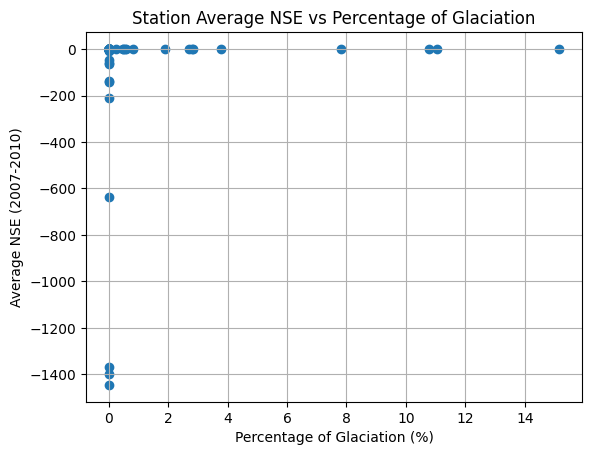

In [123]:
glac_pct = meta['pct_glaciation'].values
nse_values = np.array([station_avg_nse[str(station)] for station in stations])

plt.scatter(glac_pct, nse_values)
plt.xlabel('Percentage of Glaciation (%)')
plt.ylabel('Average NSE (2007-2010)')
plt.title('Station Average NSE vs Percentage of Glaciation')
# plt.ylim(-1,1)
plt.grid(True)
plt.show()

In [129]:
meta

,StationNum,pct_glaciation,Area_km2,lat,lon,cluster,pattern_category,glaciated,non-glaciated
0,05AA004,0.0,160.559,49.48640,-113.94769,0.232558,semi-glaciated pattern (Q2),False,False
1,05AA008,0.0,402.939,49.59732,-114.41064,0.046512,glaciated pattern (Q1),True,False
2,05AA022,0.0,820.561,49.48866,-114.14438,0.139535,semi-glaciated pattern (Q2),False,False
3,05AA028,0.0,374.216,49.39745,-114.33990,0.023256,glaciated pattern (Q1),True,False
4,05AB005,0.0,441.555,49.97735,-113.68603,0.325581,semi-glaciated pattern (Q2),False,False
...,...,...,...,...,...,...,...,...,...
106,07OA001,0.0,831.580,58.59144,-118.49104,0.488372,semi-non-glaciated pattern (Q3),False,True
107,07OB003,0.0,37042.300,59.14946,-117.63633,0.093023,semi-glaciated pattern (Q2),False,False
108,07OB004,0.0,2645.150,59.58080,-117.19649,0.465116,semi-non-glaciated pattern (Q3),False,True
109,07OB006,0.0,295.477,59.40580,-117.28072,0.395349,semi-non-glaciated pattern (Q3),False,True


In [132]:
glac_pattern = meta[meta['pattern_category'] == 'glaciated pattern (Q1)']
nse_glaciated = np.sum([station_avg_nse[str(station)] for station in glac_pattern['StationNum'].astype(str)]) / len(glac_pattern)
print(nse_glaciated)

glaciated = meta[meta['non-glaciated'] == 0]
nse_glaciated_binary = np.sum([station_avg_nse[str(station)] for station in glaciated['StationNum'].astype(str)]) / len(glaciated)
print(nse_glaciated_binary)

0.5167775022739639
0.2043965422071344


### Make predictions for the glaciated stations

In [142]:
# Make results directory
RESULTS_DIR = "modeled_streamflow_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Load metadata
meta = pd.read_csv('station_cluster_metadata.csv')
glaciated_stations = meta[meta['pct_glaciation'] > 0]['StationNum'].astype(str).tolist()

# Define test years
test_years = list(range(1980, 1990)) + list(range(2011, 2023))

MODEL_PATH = 'best_model.keras'
SCALERS_PATH = 'scalers.pkl'
SEQ_LENGTH = 365

# Load model and scalers
model, scalers = load_model_and_scalers(MODEL_PATH, SCALERS_PATH)

# Final outputs (each will be: rows = full date range, columns = stations)
glac_master = {}
noglac_master = {}
diff_master = {}

for station in glaciated_stations:
    print(f"Processing station {station}...")

    # Temporary list to hold multiple years of data for this station
    station_glac = []
    station_noglac = []
    station_diff = []

    for year in test_years:

        # Evaluate with glaciation
        dates, observed, pred_glac, _ = evaluate_station(
            model, scalers, station, year, SEQ_LENGTH
        )

        # Evaluate without glaciation
        _, _, pred_no_glac, _ = evaluate_station(
            model, scalers, station, year, SEQ_LENGTH, no_glac=True
        )

        # Yearly data as DataFrames with dates as index
        df_glac_year = pd.DataFrame(pred_glac, index=dates, columns=[station])
        df_noglac_year = pd.DataFrame(pred_no_glac, index=dates, columns=[station])
        df_diff_year = df_glac_year - df_noglac_year

        # Store for later merge
        station_glac.append(df_glac_year)
        station_noglac.append(df_noglac_year)
        station_diff.append(df_diff_year)

    # Concatenate all years vertically (continuous time series)
    glac_master[station] = pd.concat(station_glac).sort_index()
    noglac_master[station] = pd.concat(station_noglac).sort_index()
    diff_master[station] = pd.concat(station_diff).sort_index()

# Combine all stations horizontally
glac_df = pd.concat(glac_master.values(), axis=1)
noglac_df = pd.concat(noglac_master.values(), axis=1)
diff_df = pd.concat(diff_master.values(), axis=1)

# Save CSVs
glac_df.to_csv(os.path.join(RESULTS_DIR, "glaciated_predictions.csv"))
noglac_df.to_csv(os.path.join(RESULTS_DIR, "non_glaciated_predictions.csv"))
diff_df.to_csv(os.path.join(RESULTS_DIR, "glacier_difference.csv"))

print("Saved all modeled streamflow results.")

Loading model from best_model.keras...
Loading scalers from scalers.pkl...
Processing station 05AD003...

Loading data for station 05AD003...
Station metadata:
  Area: 617.31 km²
  Glaciation: 0.56%
  Available data: 1979-12-31 00:00:00 to 2022-12-31 00:00:00

Prepared 2 sequences
Prediction period: 1980-12-30 00:00:00 to 1980-12-31 00:00:00
Making predictions...


C:\Users\tbwil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['dynamic_input', 'static_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Nash-Sutcliffe Efficiency (NSE): nan

Loading data for station 05AD003...
Station metadata:
  Area: 617.31 km²
  Glaciation: 0.00%
  Available data: 1979-12-31 00:00:00 to 2022-12-31 00:00:00

Prepared 2 sequences
Prediction period: 1980-12-30 00:00:00 to 1980-12-31 00:00:00
Making predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step

Nash-Sutcliffe Efficiency (NSE): nan

Loading data for station 05AD003...
Station metadata:
  Area: 617.31 km²
  Glaciation: 0.56%
  Available data: 1979-12-31 00:00:00 to 2022-12-31 00:00:00

Prepared 365 sequences
Prediction period: 1981-01-01 00:00:00 to 1981-12-31 00:00:00
Making predictions...


C:\Users\tbwil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['dynamic_input', 'static_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step

Nash-Sutcliffe Efficiency (NSE): 0.7528

Loading data for station 05AD003...
Station metadata:
  Area: 617.31 km²
  Glaciation: 0.00%
  Available data: 1979-12-31 00:00:00 to 2022-12-31 00:00:00

Prepared 365 sequences
Prediction period: 1981-01-01 00:00:00 to 1981-12-31 00:00:00
Making predictions...
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step

Nash-Sutcliffe Efficiency (NSE): 0.6804

Loading data for station 05AD003...
Station metadata:
  Area: 617.31 km²
  Glaciation: 0.56%
  Available data: 1979-12-31 00:00:00 to 2022-12-31 00:00:00

Prepared 365 sequences
Prediction period: 1982-01-01 00:00:00 to 1982-12-31 00:00:00
Making predictions...
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step

Nash-Sutcliffe Efficiency (NSE): 0.6485

Loading data for station 05AD003...
Station metadata:
  Area: 617.31 km²
  Glaciation: 0.00%
  Available data: 1979-12-31 00:00:00 to 2022-12-31 00:00:00

Prepared 365 sequences
Prediction period: 1982-01-01 00:00:00 to 1982-12-31